In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from tensorflow import keras
from tensorflow.keras import layers
import csv

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('Grocery_Items_17.csv', 'r') as file:
    reader = csv.reader(file)
    transactions = list(reader)

# Remove empty strings and NaN values from transactions
transactions = [[item for item in transaction if item not in ["", "nan", np.nan]] for transaction in transactions]

TE = TransactionEncoder()
TE_array = TE.fit(transactions).transform(transactions)
grocery_df = pd.DataFrame(TE_array, columns=TE.columns_)

#Using minimum support = 0.01 and minimum confidence threshold = 0.1, what are the association rules you can extract from your dataset? 

frequent_itemsets = apriori(grocery_df, min_support = 0.01, use_colnames = True)
AR = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.1)
AR

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(whole milk),0.121485,0.157105,0.013498,0.111111,0.707239,-0.005588,0.948256
1,(rolls/buns),(whole milk),0.113236,0.157105,0.013873,0.122517,0.779837,-0.003917,0.960582
2,(soda),(whole milk),0.094613,0.157105,0.011999,0.126816,0.807206,-0.002866,0.965312
3,(yogurt),(whole milk),0.090239,0.157105,0.012498,0.138504,0.881600,-0.001679,0.978408


References:http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

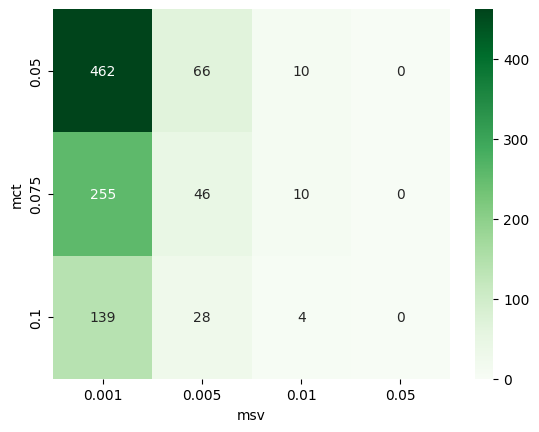

In [6]:
# Use minimum support values (msv): 0.001, 0.005, 0.01, 0.05 and minimum confidence threshold
#(mct): 0.05, 0.075, 0.1. For each pair (msv, mct), find the number of association rules extracted from
#the dataset. Construct a heatmap using Seaborn data visualization library

ARcount=[]
msv=[]
mct=[]
for i in ( 0.001, 0.005, 0.01, 0.05):
    frequent_itemsets = apriori(grocery_df,min_support = i,use_colnames = True)
    for j in (0.05, 0.075, 0.1):
        ar = association_rules(frequent_itemsets,metric = "confidence",min_threshold = j)
        ARcount.append(len(ar))
        msv.append(i)
        mct.append(j)

head_df = pd.DataFrame({'msv': msv, 'mct': mct, 'count': ARcount})

sns.heatmap(head_df.pivot('mct','msv','count'), annot=True, cmap="Greens", fmt='g')
plt.show()

        

References:https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [8]:
#List the association rule(s) (i.e., one or more rules depending on your dataset) that have the highest
#confidence for minimum support = 0.005. What is that confidence value?
frequent_item = apriori(grocery_df, min_support=0.005, use_colnames=True)
rules=association_rules(frequent_item,metric='confidence', min_threshold=0.0)
high_confidence=rules['confidence'].max()
print(high_confidence)
rules[ (rules['confidence'] == high_confidence)]

0.17486338797814205


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(bottled beer),(whole milk),0.045744,0.157105,0.007999,0.174863,1.113033,0.000812,1.021521


In [23]:
# Model / data parameters
num_classes = 4
input_shape = (100, 100, 1)

image_dir='DMresizedimages'
def process_image(image_dir):
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE) 
    return image
X = []  
Y = []  
for image_filename in os.listdir(image_dir):
    if image_filename.endswith(".jpg"):
        image_path = os.path.join(image_dir, image_filename)
        class_name = image_filename.split('_')[0]
        img = process_image(image_path)
        Y.append(class_name)
        X.append(img)
X = np.array(X)
Y = np.array(Y)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

x_train,x_test,y_train,y_test=train_test_split(X,Y_encoded,test_size=0.2,stratify=Y_encoded,random_state=42)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (552, 100, 100, 1)
552 train samples
138 test samples


References:https://keras.io/examples/vision/mnist_convnet/

In [24]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(16,activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19208)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                307344    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 307,492
Trainable params: 307,492
Non-trainable params: 0
_________________________________________________________________


References:https://keras.io/examples/vision/mnist_convnet/

In [26]:
batch_size = 64
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test))

Train on 552 samples, validate on 138 samples
Epoch 1/20
552/552 [==============================] - 1s 2ms/sample - loss: 0.5655 - accuracy: 0.8460 - val_loss: 1.1196 - val_accuracy: 0.5290
Epoch 2/20
552/552 [==============================] - 1s 909us/sample - loss: 0.4899 - accuracy: 0.8967 - val_loss: 1.0898 - val_accuracy: 0.5507
Epoch 3/20
552/552 [==============================] - 1s 967us/sample - loss: 0.4413 - accuracy: 0.9384 - val_loss: 1.0868 - val_accuracy: 0.5507
Epoch 4/20
552/552 [==============================] - 1s 937us/sample - loss: 0.4137 - accuracy: 0.9312 - val_loss: 1.0799 - val_accuracy: 0.5870
Epoch 5/20
552/552 [==============================] - 1s 965us/sample - loss: 0.3612 - accuracy: 0.9402 - val_loss: 1.1067 - val_accuracy: 0.5435
Epoch 6/20
552/552 [==============================] - 1s 986us/sample - loss: 0.3429 - accuracy: 0.9475 - val_loss: 1.0996 - val_accuracy: 0.5580
Epoch 7/20
552/552 [==============================] - 1s 943us/sample - loss: 0.

References:https://keras.io/examples/vision/mnist_convnet/

In [27]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1815785722456116
Test accuracy: 0.5942029


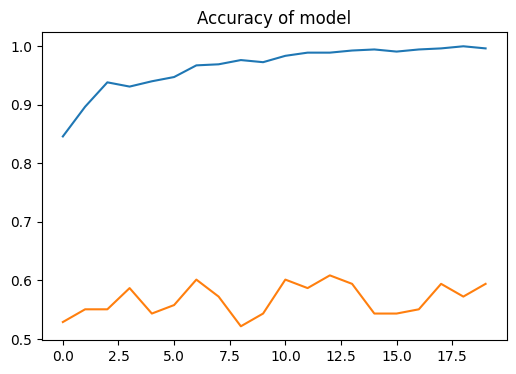

In [28]:
plt.figure(figsize=(6,4))
plt.plot(model.history.history['accuracy'],label='training')
plt.plot(model.history.history['val_accuracy'],label='validation')
plt.title('Accuracy of model')
plt.show()

model overfit the data

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 8)         208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                294928    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 295,204
Trainable params: 295,204
Non-trainable params: 0
_________________________________________________________________
Train on 552 samples, validate on 138 samples
Epoch 1/20
552/552 [==============================] - 2s 3ms/sample 

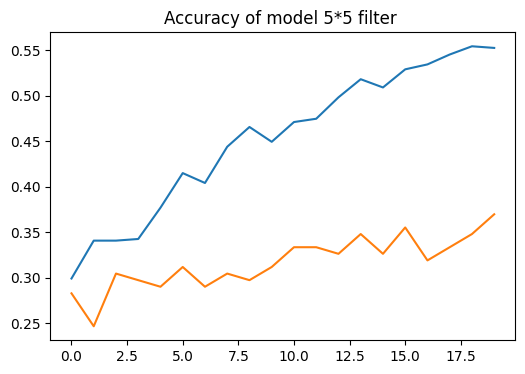

In [29]:
#banner id: 916457963
#Train the CNN using 2 other filter sizes: 5 × 5 and 7 × 7 for the convolution layer (i) with all other parameters unchanged
#model with 5*5
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(16,activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test))

plt.figure(figsize=(6,4))
plt.plot(model.history.history['accuracy'],label='training')
plt.plot(model.history.history['val_accuracy'],label='validation')
plt.title('Accuracy of model 5*5 filter ')
plt.show()

References:https://keras.io/examples/vision/mnist_convnet/

model overfit

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 94, 94, 8)         400       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 17672)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                282768    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 68        
Total params: 283,236
Trainable params: 283,236
Non-trainable params: 0
_________________________________________________________________
Train on 552 samples, validate on 138 samples
Epoch 1/20
552/552 [==============================] - 1s 2ms/sample 

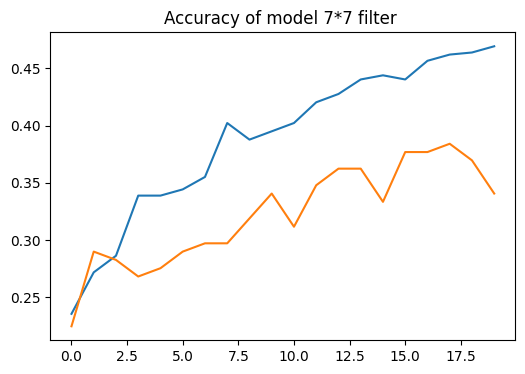

In [30]:
#model with 7*7
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(7, 7), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(16,activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test))

plt.figure(figsize=(6,4))
plt.plot(model.history.history['accuracy'],label='training')
plt.plot(model.history.history['val_accuracy'],label='validation')
plt.title('Accuracy of model 7*7 filter ')
plt.show()

References:https://keras.io/examples/vision/mnist_convnet/

model overfit